In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
sns.set(rc={'figure.figsize':(12,5)})
%load_ext autoreload
%autoreload 2 

In [239]:
from tqdm import tqdm

In [119]:
import sys
import os
import itertools
import re
from functools import cmp_to_key
sys.path.append(os.path.abspath('../modules'))
from hard_rules import candidate_cookies, versions_key, compare_versions, trim_version

In [3]:
data = pd.read_parquet("../Data/10K_HH.parquet")

In [4]:
data = data[data["maid"]==7]

In [5]:
data["time"].apply(lambda t: (t.year, t.month)).value_counts().sort_index()

(2021, 12)         56
(2022, 1)         365
(2022, 2)          22
(2022, 12)    1329060
(2023, 1)     1402187
(2023, 2)      669026
Name: time, dtype: int64

In [6]:
data = data[data["time"] >= pd.to_datetime("2022-12-01")]

In [7]:
pattern = re.compile(r'^\d+(\.\d+)*$')
data = data[data.osversion.str.match(pattern)]

In [8]:
pattern = re.compile(r'^\d+(\.\d+)*$')
data = data[data.browserversion.str.match(pattern)]

In [9]:
data.sort_values(by="time")

,timestamp,filename,iiqid,hh_id,maid,partner_id,ip,iscellip,cellispid,domain,...,model,os,osversion,browser,advertisedbrowser,browserversion,type,is_best_ip,time,is_hh
5305360,1669852802551,HH_M,WorsfJNhdF,OVfCx6ZAeC,7,10253,1014397863,False,-1793086944,-1297673767,...,edge,windows,10,edge,Edge,107.0.1418.56,desktop,False,2022-12-01 00:00:02.551,True
274574,1669852802551,HH_M,WorsfJNhdF,OVfCx6ZAeC,7,10253,1014397863,False,-1793086944,-1297673767,...,edge,windows,10,edge,Edge,107.0.1418.56,desktop,False,2022-12-01 00:00:02.551,True
5799545,1669852815024,NHB_M,xR6Olq5vyY,1096230683,7,14,1096235864,False,-785738892,1632511751,...,sm-g950u,android,9,chrome mobile,Facebook on Android,9,smartphone,False,2022-12-01 00:00:15.024,True
1884467,1669852821516,HH_M,3bsIDAAL9s,uH94IApkve,7,14,1255127361,False,1891219528,-1545077811,...,chrome,windows,10,chrome desktop,Chrome,108.0.0.0,desktop,False,2022-12-01 00:00:21.516,True
6016795,1669852821516,HH_M,3bsIDAAL9s,uH94IApkve,7,14,1255127361,False,1891219528,-1545077811,...,chrome,windows,10,chrome desktop,Chrome,108.0.0.0,desktop,False,2022-12-01 00:00:21.516,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8296392,1677159416733,NHB_M,Ds994Aq4Kq,1097159426,7,14,1097159426,False,1205978362,-1043038672,...,sm-g950u,android,9,chrome mobile,Chromium,110.0.5481.65,smartphone,False,2023-02-23 13:36:56.733,True
8203159,1677159846956,NHB_M,EcAoAoIxDi,832838830,7,10253,832838830,False,-494206676,1702609264,...,sm-g996n,android,13,chrome mobile,Chrome Mobile,110.0.0.0,smartphone,False,2023-02-23 13:44:06.956,True
8296391,1677160051244,NHB_M,Ds994Aq4Kq,1097159426,7,14,1097159426,False,1205978362,303931829,...,sm-g950u,android,9,chrome mobile,Chromium,110.0.5481.65,smartphone,False,2023-02-23 13:47:31.244,True
8281614,1677160560033,HH_M,gzxxSoJdWU,2plgjo3PiK,7,14,1087495473,False,-1093811737,-1838687026,...,t810s,android,12,chrome mobile,Facebook on Android,12,smartphone,False,2023-02-23 13:56:00.033,True


In [10]:
grouped = data.groupby(['hh_id', 'iiqid']).agg({'time': ['min', 'max']})

In [11]:
grouped["lifespan"] = grouped[("time", "max")] - grouped[("time", "min")]

In [12]:
grouped["lifespan"] = grouped["lifespan"].apply(lambda t: t.days)

In [18]:
grouped.head()

time                         lifespan
                                          min                     max         
hh_id      iiqid                                                              
008lj1AMI8 6MILYBoI9P 2022-12-06 20:30:42.973 2023-02-03 17:29:52.687       58
           UVg62Vt8Va 2022-12-04 06:04:54.956 2023-02-03 22:48:53.120       61
           WATS0P8zVm 2023-01-04 09:04:24.973 2023-02-08 09:39:50.615       35
           mXwL7QCw5O 2022-12-02 17:01:54.895 2023-02-08 13:58:34.536       67
           vjNRSKwlH4 2022-12-01 20:43:03.895 2023-01-05 06:20:52.917       34

In [12]:
data.head()

,timestamp,filename,iiqid,hh_id,maid,partner_id,ip,iscellip,cellispid,domain,...,model,os,osversion,browser,advertisedbrowser,browserversion,type,is_best_ip,time,is_hh
317,1672454576791,HH_M,DkRTpvzRBp,2RrCJATsw0,7,15019,2935173494,True,1256337485,831946351,...,iphone,ios,16.0,safari,Mobile Safari,16.0,smartphone,False,2022-12-31 02:42:56.791,True
318,1672418570693,HH_M,DkRTpvzRBp,2RrCJATsw0,7,15019,1645510743,False,-390920904,831946351,...,iphone,ios,16.0,safari,Mobile Safari,16.0,smartphone,False,2022-12-30 16:42:50.693,True
319,1672278111596,HH_M,DkRTpvzRBp,2RrCJATsw0,7,15019,1193046921,False,-390920904,831946351,...,iphone,ios,16.0,safari,Mobile Safari,16.0,smartphone,False,2022-12-29 01:41:51.596,True
320,1672186457438,HH_M,DkRTpvzRBp,2RrCJATsw0,7,15019,1645512144,False,-390920904,831946351,...,iphone,ios,16.0,safari,Mobile Safari,16.0,smartphone,False,2022-12-28 00:14:17.438,True
321,1671982417563,HH_M,DkRTpvzRBp,2RrCJATsw0,7,15019,1645512144,False,-390920904,831946351,...,iphone,ios,16.0,safari,Mobile Safari,16.0,smartphone,False,2022-12-25 15:33:37.563,True


In [13]:
grouped.lifespan.max()

84

<Axes: xlabel='lifespan', ylabel='Count'>

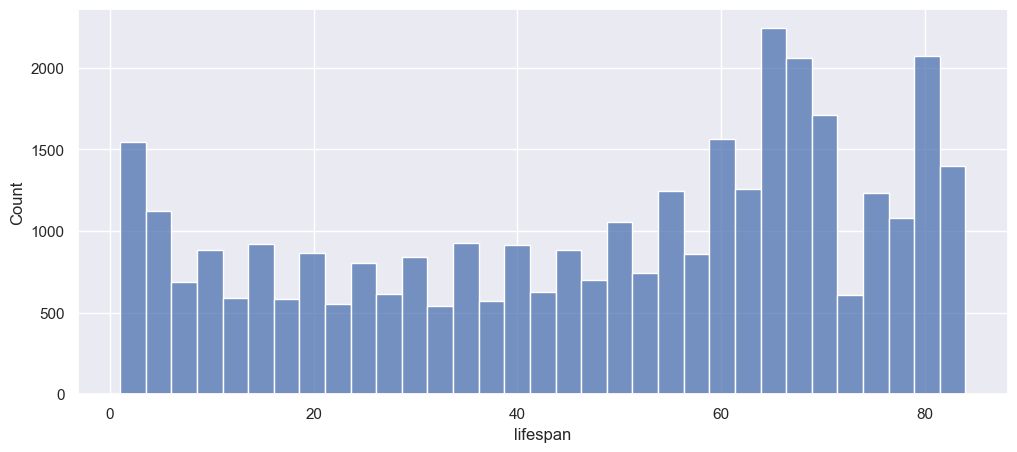

In [14]:
sns.histplot(data=grouped[grouped["lifespan"]>0], x="lifespan")
# sns.histplot(data=grouped, x="lifespan")

<BarContainer object of 2 artists>

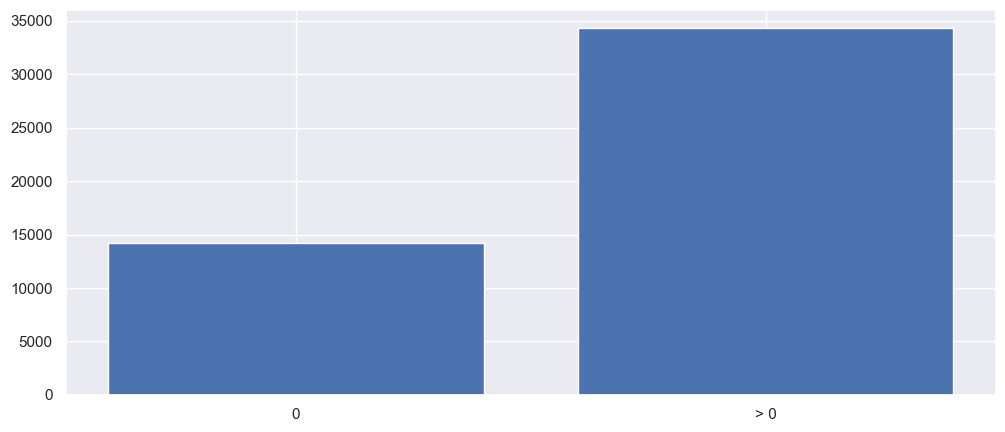

In [15]:
plt.bar(["0","> 0"], 
        [len(grouped[grouped["lifespan"]==0]), len(grouped[grouped["lifespan"]>0])])

In [16]:
grouped.head()

time                         lifespan
                                          min                     max         
hh_id      iiqid                                                              
008lj1AMI8 6MILYBoI9P 2022-12-06 20:30:42.973 2023-02-03 17:29:52.687       58
           UVg62Vt8Va 2022-12-04 06:04:54.956 2023-02-03 22:48:53.120       61
           WATS0P8zVm 2023-01-04 09:04:24.973 2023-02-08 09:39:50.615       35
           mXwL7QCw5O 2022-12-02 17:01:54.895 2023-02-08 13:58:34.536       67
           vjNRSKwlH4 2022-12-01 20:43:03.895 2023-01-05 06:20:52.917       34

In [17]:
one_row = grouped[grouped["lifespan"] > 60].sample(1)
one_row

time                         lifespan
                                          min                     max         
hh_id      iiqid                                                              
pf5jEgESJa WosrCrerQi 2022-12-08 05:19:27.969 2023-02-07 14:49:18.291       61

In [90]:
one_cookie = one_row.index.get_level_values(1).values[0]

In [91]:
one_cookie

'Bcjz15r0Ms'

In [92]:
one_cookie_data = data[data["iiqid"]==one_cookie]

In [93]:
one_cookie_data.browser.value_counts()

chrome mobile    37
Name: browser, dtype: int64

In [94]:
most_common_brw = one_cookie_data.browser.mode().iloc[0]

In [95]:
one_cookie_data = one_cookie_data[one_cookie_data["browser"]==most_common_brw]

<Axes: xlabel='time', ylabel='browserversion'>

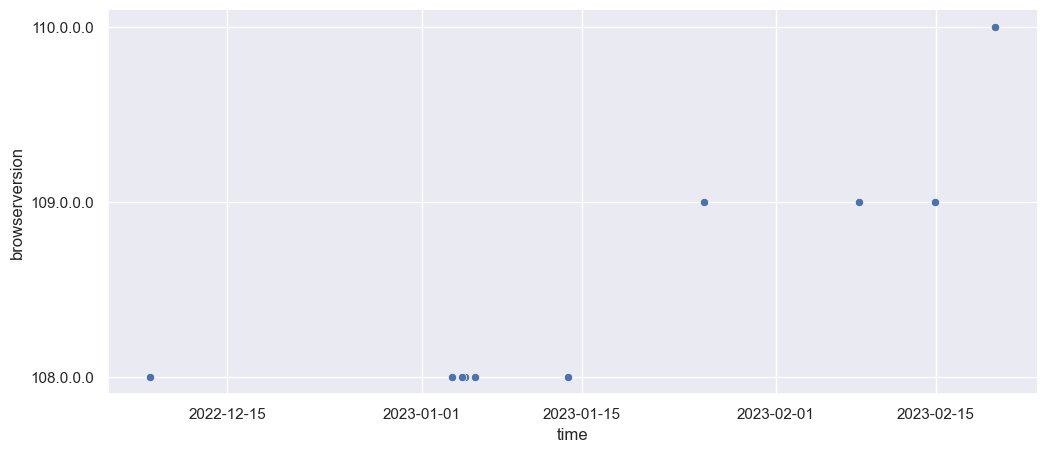

In [96]:
sns.scatterplot(data=one_cookie_data, x="time", y="browserversion")

## Lets try to find how many error are they

For a given cookie:
Go over all of its apearesnces and see if the browserversion stays consistent.
Lets strat by a simple "yes/no" test.

In [99]:
one_cookie_data = one_cookie_data.sort_values(by="time")

In [108]:
one_cookie_data["prev_browserversion"] = one_cookie_data["browserversion"].shift(1).fillna("0.0.0.0")

In [115]:
all(np.vectorize(compare_versions)(one_cookie_data['prev_browserversion'], one_cookie_data['browserversion']) <= 0)

True

In [75]:
def has_no_errors(cookie, df=data):
    one_cookie_data = df[df["iiqid"]==cookie].sort_values(by="time")
    one_cookie_data["prev_browserversion"] = one_cookie_data["browserversion"].shift(1).fillna("0.0.0.0")
    one_cookie_data["prev_osversion"] = one_cookie_data["osversion"].shift(1).fillna("0")
    browser_consistency = all(np.vectorize(compare_versions)(one_cookie_data['prev_browserversion'], one_cookie_data['browserversion']) <= 0)
    os_consistency = all(np.vectorize(compare_versions)(one_cookie_data['osversion'], one_cookie_data['osversion']) <= 0)
    return browser_consistency and os_consistency

In [119]:
has_no_errors(one_cookie)

True

In [13]:
data.sort_values(by="time", inplace=True)
# grouped_cookies = data.groupby(["hh_id", "iiqid"])

In [25]:
data[data['hh_id']=='1097159426'][['hh_id', 'iiqid', 'osversion']]

,hh_id,iiqid,osversion
8297176,1097159426,Ds994Aq4Kq,9
8297175,1097159426,Ds994Aq4Kq,9
8297174,1097159426,Ds994Aq4Kq,9
8297173,1097159426,Ds994Aq4Kq,9
8297172,1097159426,Ds994Aq4Kq,9
...,...,...,...
8296372,1097159426,I2g1DDxkA3,9
8296371,1097159426,I2g1DDxkA3,9
8296072,1097159426,k78WlySg6A,9
8296392,1097159426,Ds994Aq4Kq,9


In [21]:
data.groupby(['hh_id', 'iiqid'])['osversion'].shift(1)

5305360    NaN
274574      10
5799545    NaN
1884467    NaN
6016795     10
          ... 
8296392      9
8203159     13
8296391      9
8281614     12
8281613     12
Name: osversion, Length: 3400058, dtype: object

In [14]:
data['prev_osversion'] = data.groupby(['hh_id', 'iiqid'])['osversion'].shift(1).fillna("0")
data['prev_browserversion'] = data.groupby(['hh_id', 'iiqid'])['browserversion'].shift(1).fillna("0.0.0.0")

In [15]:
data[data['hh_id']==data['hh_id'].sample(1).values[0]].set_index(['hh_id', 'iiqid']).to_csv('temp.csv')

In [16]:
full_valid_rows = data[(np.vectorize(compare_versions)(data['osversion'], 
                                                         data['prev_osversion']) >= 0)
                       & (np.vectorize(compare_versions)(data['browserversion'], 
                                                               data['prev_browserversion']) >= 0)]

In [17]:
ok_rows_counts = full_valid_rows.groupby(['hh_id', 'iiqid']).size()

In [18]:
total_rows_counts = data.groupby(['hh_id', 'iiqid']).size()

In [19]:
all_ok = ok_rows_counts.eq(total_rows_counts)

In [20]:
all_ok.head(1)

hh_id       iiqid     
008lj1AMI8  6MILYBoI9P    True
dtype: bool

In [21]:
result = pd.concat([total_rows_counts, all_ok], axis=1)
result.columns = ['instances','ok'] 

In [21]:
result.head()

instances     ok
hh_id      iiqid                       
008lj1AMI8 6MILYBoI9P         66  False
           UVg62Vt8Va         41  False
           WATS0P8zVm        156  False
           mXwL7QCw5O         51  False
           vjNRSKwlH4         28   True

<Axes: xlabel='ok', ylabel='count'>

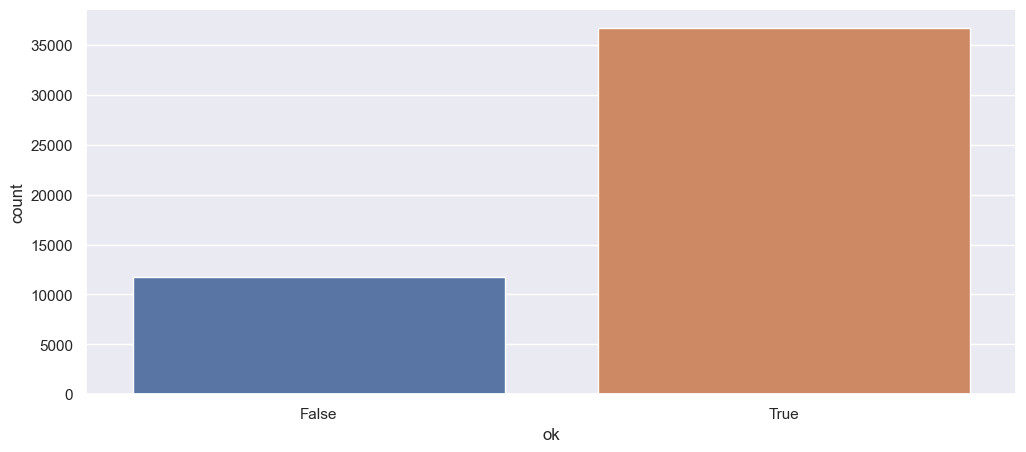

In [52]:
sns.countplot(data=result, x='ok')

In [22]:
cookie_hhd_data = pd.concat([grouped, result], axis=1)
cookie_hhd_data.columns = ["time_min", "time_max", "lifespan", "instances", "ok"]

In [54]:
lifespan_order = [str(i) for i in range(84, -1, -1)]

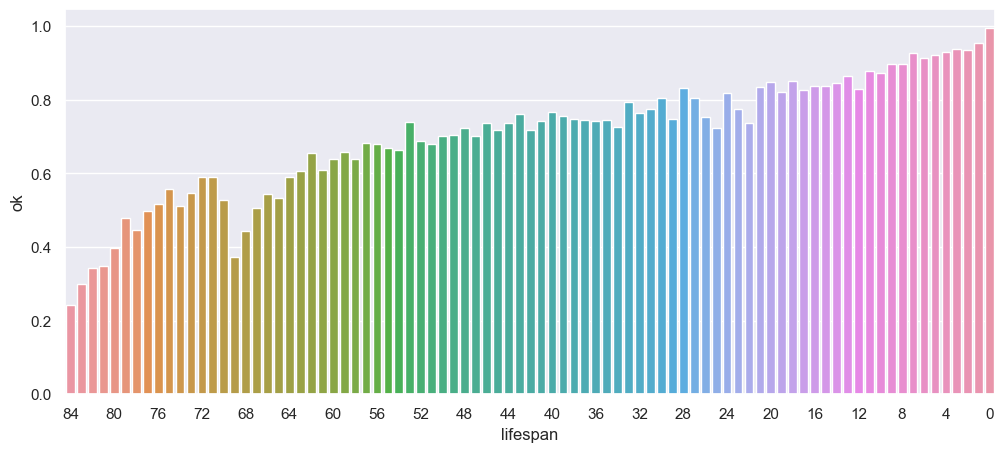

In [55]:
sns.barplot(data=cookie_hhd_data, x="lifespan", y="ok", errorbar=None, order=list(reversed(range(0, 85))))
plt.xticks(range(0, 85, 4));

In [23]:
found = False
limit_search = 1000
while not found and limit_search > 0:
    limit_search -= 1
    one_cookie_sample = cookie_hhd_data[cookie_hhd_data["ok"]==False].sample()
    one_cookie_id = one_cookie_sample.index.get_level_values(1).values[0]
    one_cookie_data = data[data["iiqid"]==one_cookie_id].copy()
    # browsers_of_cookie = one_cookie_data.browser.value_counts().sort_values(ascending=False)
    browsers_of_cookie = len(one_cookie_data.browser.unique())
    os_of_cookie = len(one_cookie_data.os.unique())
    if browsers_of_cookie == 1 and os_of_cookie == 1:
        # if len(browsers_of_cookie) > 1:
        # if browsers_of_cookie.iloc[1]  > browsers_of_cookie.sum()/4:
        found = True
if found:
    print("Found!")
else:
    print("Not Found")

Found!


In [173]:
# one_cookie_data.browser

In [160]:
one_cookie_sample = cookie_hhd_data[cookie_hhd_data["ok"]==False].sample()

In [161]:
one_cookie_id = one_cookie_sample.index.get_level_values(1).values[0]

In [162]:
one_cookie_data = data[data["iiqid"]==one_cookie_id]

In [163]:
browsers_of_cookie = one_cookie_data.browser.value_counts().sort_values(ascending=False)

In [164]:
browsers_of_cookie.sum()/4

48.5

In [175]:
one_cookie_data.browser.value_counts()

edge    246
Name: browser, dtype: int64

In [176]:
ordered_versions = sorted(one_cookie_data.browserversion.unique(), key=cmp_to_key(compare_versions))

<Axes: xlabel='time', ylabel='browserversion'>

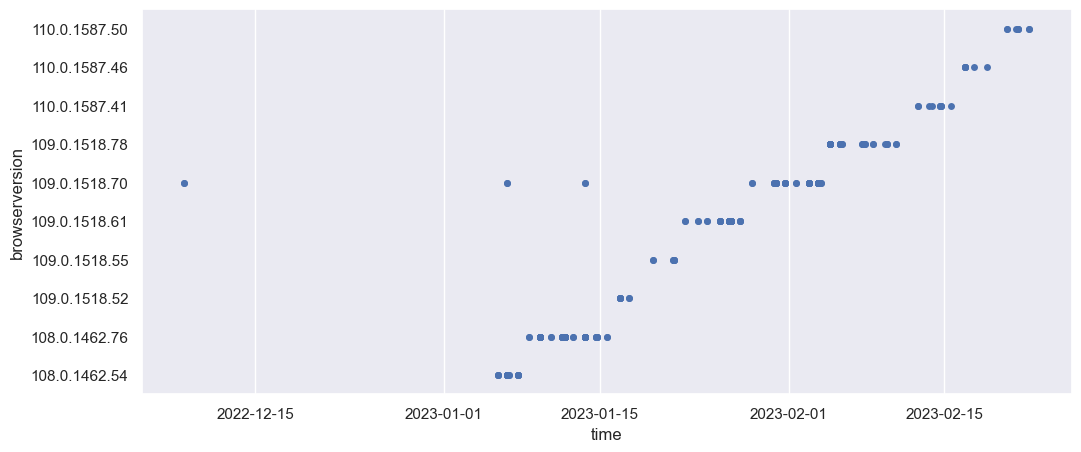

In [177]:
sns.stripplot(data=one_cookie_data, x="time", y="browserversion", 
              order=ordered_versions[::-1], jitter=False)

In [178]:
# one_cookie_data[one_cookie_data["browserversion"].apply(lambda v: v[0]=="2")]

In [179]:
one_cookie_id

'cUO4TrcMgH'

<Axes: title={'center': "Cookie's iiqid: cUO4TrcMgH"}>

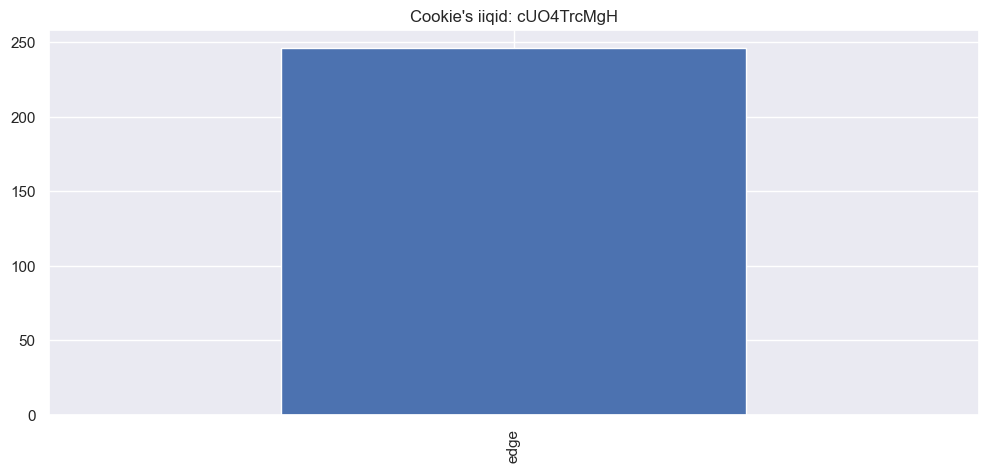

In [180]:
one_cookie_data.browser.value_counts().plot.bar(title=f"Cookie's iiqid: {one_cookie_id}")

## Mixed Constant For One Cookie

In [152]:
# data.groupby(["hh_id", "iiqid", 

In [321]:
unique_values_per_cookie = data.groupby(["hh_id", "iiqid"])[["timestamp", "brand", "model", "os", "browser", "advertisedbrowser"]].nunique()

In [322]:
unique_values_per_cookie["sum"] = unique_values_per_cookie.iloc[:,1:].sum(axis=1)

In [324]:
# Originnaly there where only 4 columns and the 'ok' sum was 4
equal_4 = unique_values_per_cookie[unique_values_per_cookie["sum"]==5]
more_than_4 = unique_values_per_cookie[unique_values_per_cookie["sum"]>5]

Text(0.5, 1.0, 'Number of user agents assosiated with each cookie')

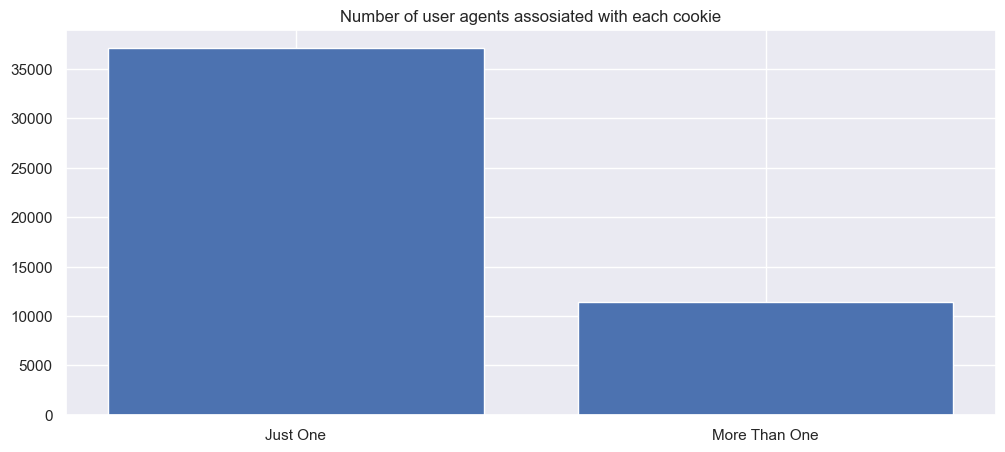

In [325]:
plt.bar(["Just One", "More Than One"], [len(equal_4), len(more_than_4)])
plt.title("Number of user agents assosiated with each cookie")

In [326]:
column_pick = "browser"
browser_counts = data.groupby(["hh_id", "iiqid"])[column_pick].value_counts()

In [327]:
unstacked_browser_counts = browser_counts.unstack(level=2).fillna(0).astype(int)

In [328]:
unstacked_browser_counts["mode"] = unstacked_browser_counts.idxmax(axis=1)

In [329]:
unstacked_browser_counts["total"] = unstacked_browser_counts.select_dtypes('number').sum(axis=1)

In [330]:
def get_value(row):
    return row[row['mode']]

unstacked_browser_counts["mode_count"] = unstacked_browser_counts.apply(get_value, axis=1)

In [331]:
unstacked_browser_counts["mode_fraction"] = unstacked_browser_counts["mode_count"] / unstacked_browser_counts["total"]

Text(0.5, 1.0, 'Distribution of UA homogeneity per cookie')

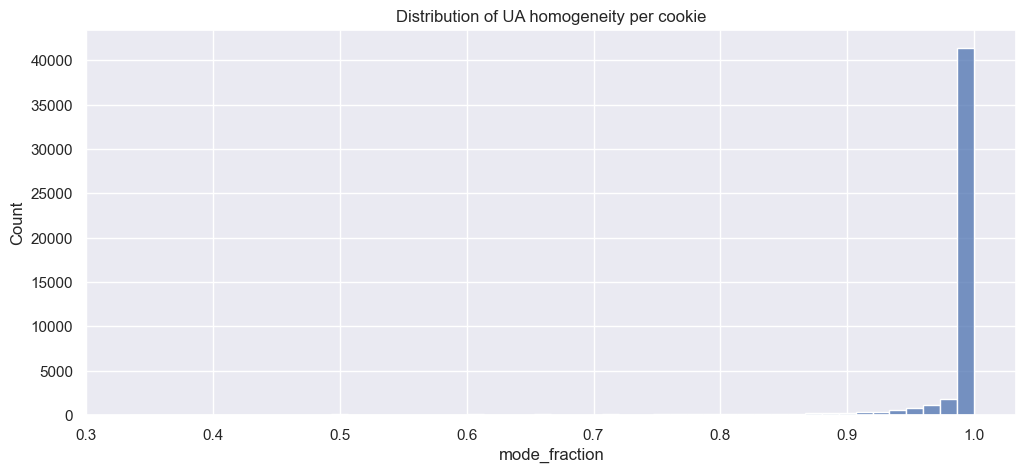

In [332]:
sns.histplot(data=unstacked_browser_counts, x="mode_fraction", bins=50)
plt.title("Distribution of UA homogeneity per cookie")

Text(0.5, 1.0, 'Distribution of UA homogeneity per cookie')

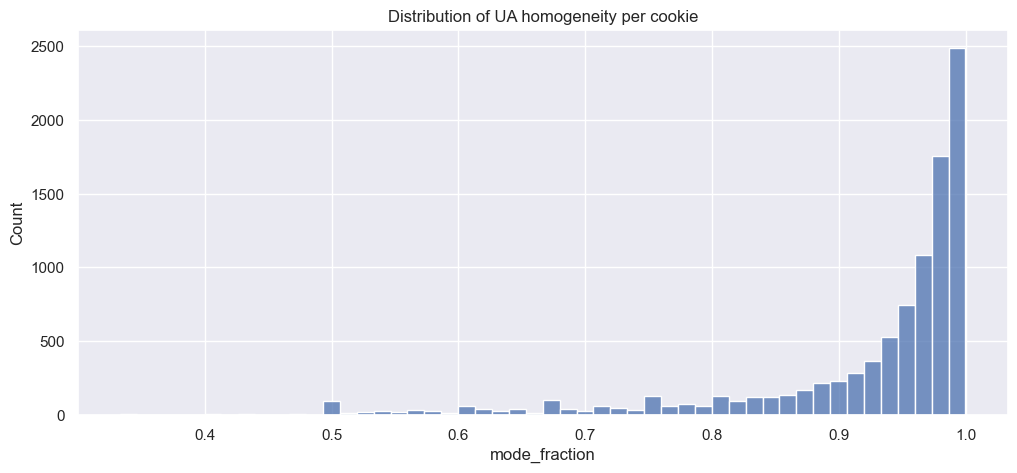

In [333]:
sns.histplot(data=unstacked_browser_counts[unstacked_browser_counts["mode_fraction"] < 1], x="mode_fraction", bins=50)
plt.title("Distribution of UA homogeneity per cookie")

## ow many errors are they, if we exclude the mixed UA

In [334]:
non_mixed_data = data[data["iiqid"].isin(equal_4.index.get_level_values(1).to_list())]

In [335]:
non_mixed_data = non_mixed_data.sort_values(by="time")

In [336]:
non_mixed_data['prev_osversion'] = non_mixed_data.groupby(['hh_id', 'iiqid'])['osversion'].shift(1).fillna("0")
non_mixed_data['prev_browserversion'] = non_mixed_data.groupby(['hh_id', 'iiqid'])['browserversion'].shift(1).fillna("0.0.0.0")

In [337]:
full_valid_rows = non_mixed_data[(np.vectorize(compare_versions)(non_mixed_data['osversion'], 
                                                         non_mixed_data['prev_osversion']) >= 0)
                       & (np.vectorize(compare_versions)(non_mixed_data['browserversion'], 
                                                               non_mixed_data['prev_browserversion']) >= 0)]

In [338]:
ok_rows_counts = full_valid_rows.groupby(['hh_id', 'iiqid']).size()

In [339]:
total_rows_counts = non_mixed_data.groupby(['hh_id', 'iiqid']).size()

In [340]:
all_ok = ok_rows_counts.eq(total_rows_counts)

In [341]:
result = pd.concat([total_rows_counts, all_ok], axis=1)
result.columns = ['instances','ok'] 

<Axes: xlabel='ok', ylabel='count'>

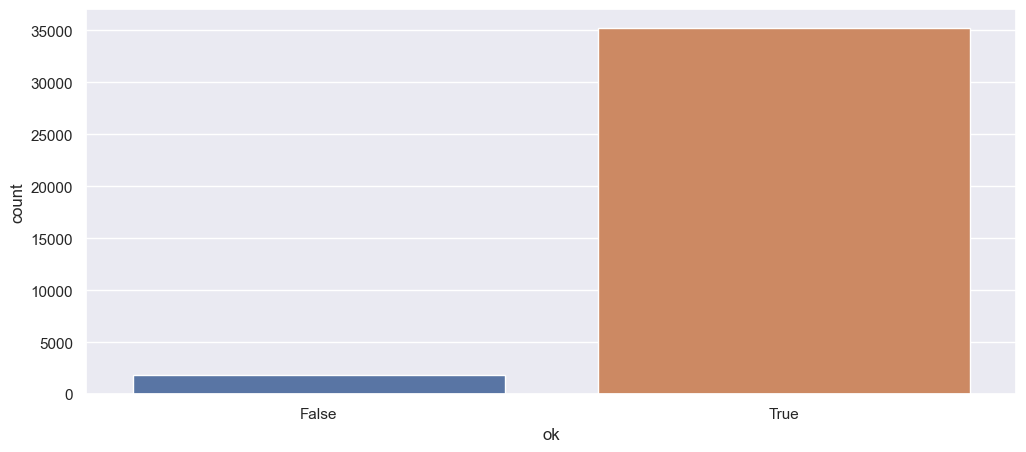

In [342]:
sns.countplot(data=result, x='ok')

In [343]:
grouped = non_mixed_data.groupby(['hh_id', 'iiqid']).agg({'time': ['min', 'max']})

In [344]:
grouped["lifespan"] = grouped[("time", "max")] - grouped[("time", "min")]

In [345]:
grouped["lifespan"] = grouped["lifespan"].apply(lambda t: t.days)

In [346]:
cookie_hhd_data = pd.concat([grouped, result], axis=1)
cookie_hhd_data.columns = ["time_min", "time_max", "lifespan", "instances", "ok"]

In [347]:
lifespan_order = [str(i) for i in range(84, -1, -1)]

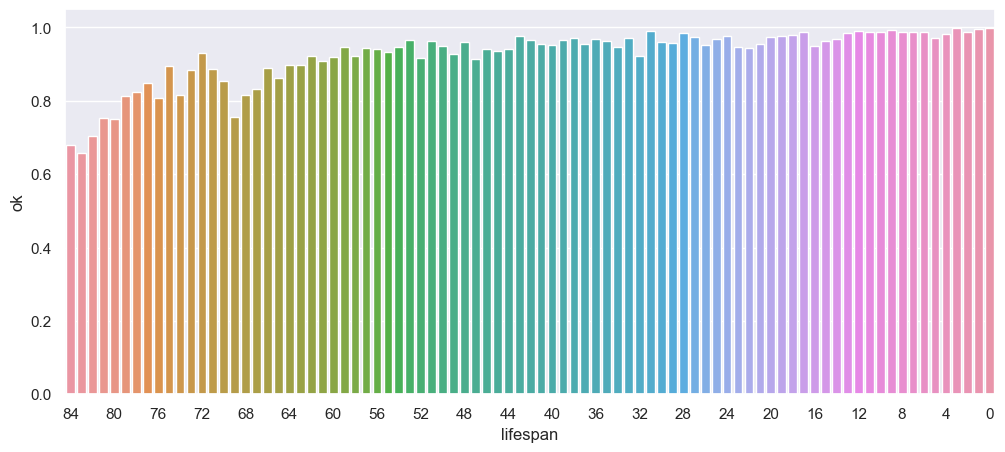

In [348]:
sns.barplot(data=cookie_hhd_data, x="lifespan", y="ok", errorbar=None, order=list(reversed(range(0, 85))))
plt.xticks(range(0, 85, 4));

In [129]:
# cookie_hhd_data["instances"].plot.hist()
sum(cookie_hhd_data["instances"] > 500) / len(cookie_hhd_data)

0.005588064737202804

<Axes: xlabel='instances', ylabel='ok'>

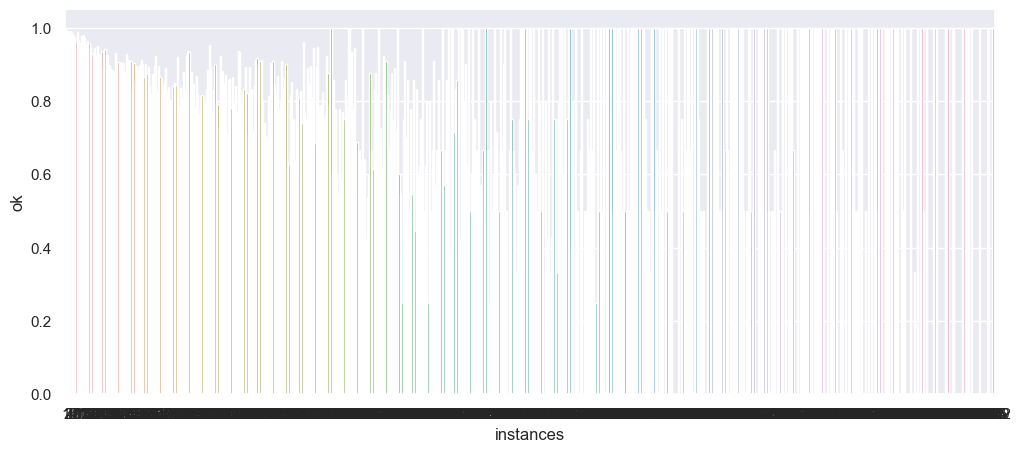

In [137]:
sns.barplot(data=cookie_hhd_data, x="instances", y="ok", errorbar=None) #, order=list(reversed(range(0, 85))))
# plt.xticks(range(0, 500, 50))
# plt.xlim(0, 500);

In [136]:
cookie_hhd_data.head()

time_min                time_max  \
hh_id      iiqid                                                        
008lj1AMI8 6MILYBoI9P 2022-12-06 20:30:42.973 2023-02-03 17:29:52.687   
           UVg62Vt8Va 2022-12-04 06:04:54.956 2023-02-03 22:48:53.120   
           WATS0P8zVm 2023-01-04 09:04:24.973 2023-02-08 09:39:50.615   
           mXwL7QCw5O 2022-12-02 17:01:54.895 2023-02-08 13:58:34.536   
           vjNRSKwlH4 2022-12-01 20:43:03.895 2023-01-05 06:20:52.917   

                       lifespan  instances    ok  
hh_id      iiqid                                  
008lj1AMI8 6MILYBoI9P        58         66  True  
           UVg62Vt8Va        61         41  True  
           WATS0P8zVm        35        156  True  
           mXwL7QCw5O        67         51  True  
           vjNRSKwlH4        34         28  True

In [244]:
found = False
while not found:
    one_cookie_sample = cookie_hhd_data[cookie_hhd_data["ok"]==False].sample()
    one_cookie_id = one_cookie_sample.index.get_level_values(1).values[0]
    one_cookie_data = data[data["iiqid"]==one_cookie_id]
    browsers_of_cookie = one_cookie_data.browser.value_counts().sort_values(ascending=False)
    if browsers_of_cookie.sum() > 25:
        if len(browsers_of_cookie) == 1:
            found = True

In [245]:
ordered_versions = sorted(one_cookie_data.browserversion.unique(), key=cmp_to_key(compare_versions))

Text(0.5, 1.0, "Cookie's iiqid: uwMFDFZwoX")

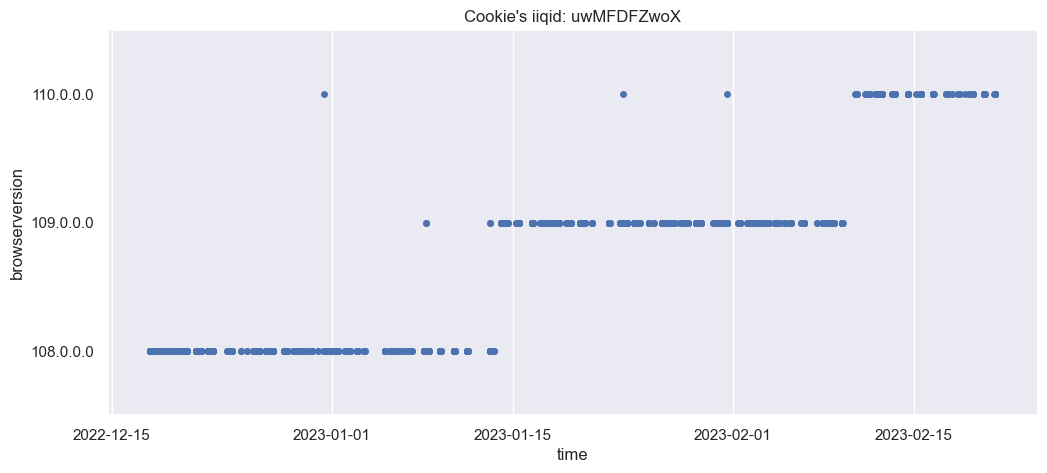

In [246]:
sns.stripplot(data=one_cookie_data, x="time", y="browserversion", 
              order=ordered_versions[::-1], jitter=False)
plt.title(f"Cookie's iiqid: {one_cookie_id}")

In [247]:
one_cookie_data.to_csv("another_example_for_version_noise.csv")

## Isotonic Regression

In [54]:
import sklearn as sk
from sklearn.isotonic import IsotonicRegression

In [46]:
single_example = one_cookie_data.copy()

In [47]:
ordered_versions = sorted(single_example.browserversion.unique(), key=cmp_to_key(compare_versions))

Text(0.5, 1.0, "Cookie's iiqid: PKkiFbUF6P")

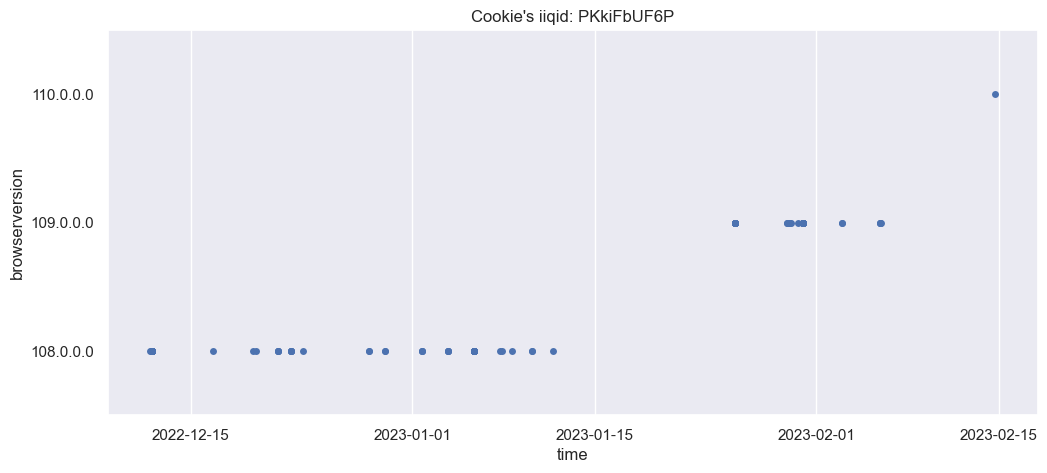

In [48]:
sns.stripplot(data=single_example, x="time", y="browserversion", 
              order=ordered_versions[::-1], jitter=False)
plt.title(f"Cookie's iiqid: {one_cookie_id}")

In [55]:
isotonic = IsotonicRegression() #out_of_bounds='clip')

In [196]:
serialized_browserversions = dict(enumerate(ordered_versions))

In [49]:
single_example['serial_browserversion'] = None

In [50]:
single_example['serial_browserversion'] = single_example['browserversion'].apply(lambda v: ordered_versions.index(v))

Text(0.5, 1.0, "Cookie's iiqid: PKkiFbUF6P")

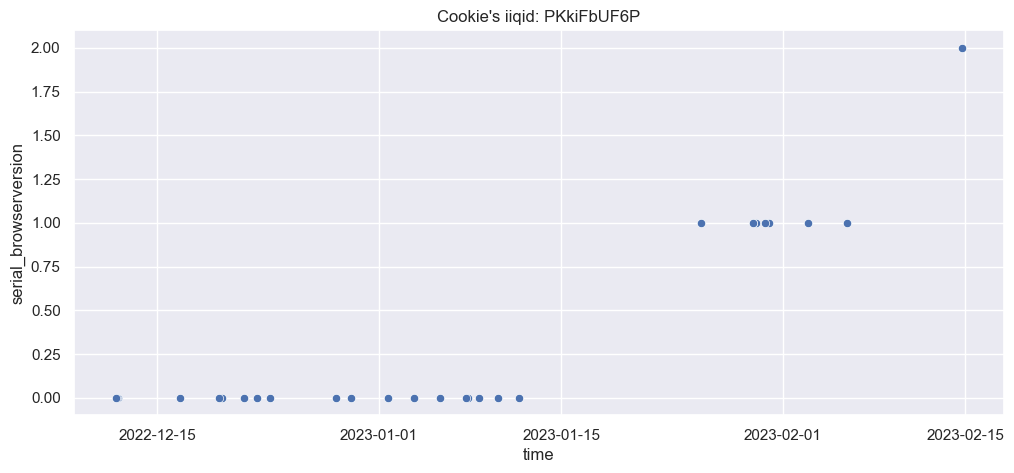

In [51]:
sns.scatterplot(data=single_example, x="time", y="serial_browserversion")#, jitter=False)
plt.title(f"Cookie's iiqid: {one_cookie_id}")

In [56]:
regressed_version = isotonic.fit_transform(single_example.time, single_example.serial_browserversion).round()

In [57]:
mask = np.where(single_example.serial_browserversion != regressed_version)

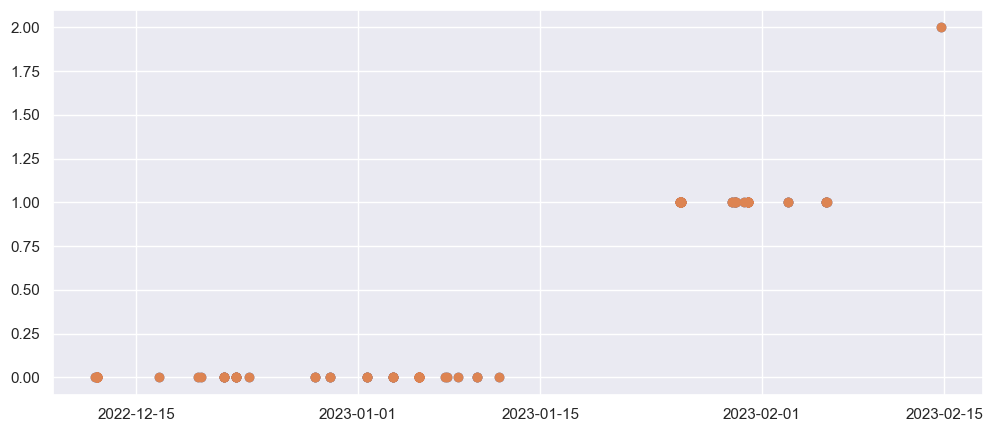

In [58]:
plt.scatter(single_example.time, regressed_version)
plt.scatter(single_example.time, single_example.serial_browserversion)
plt.scatter(single_example.time.iloc[mask], regressed_version[mask], s=200)

In [23]:
from lnds import longest_non_decreasing_subsequence as lnds

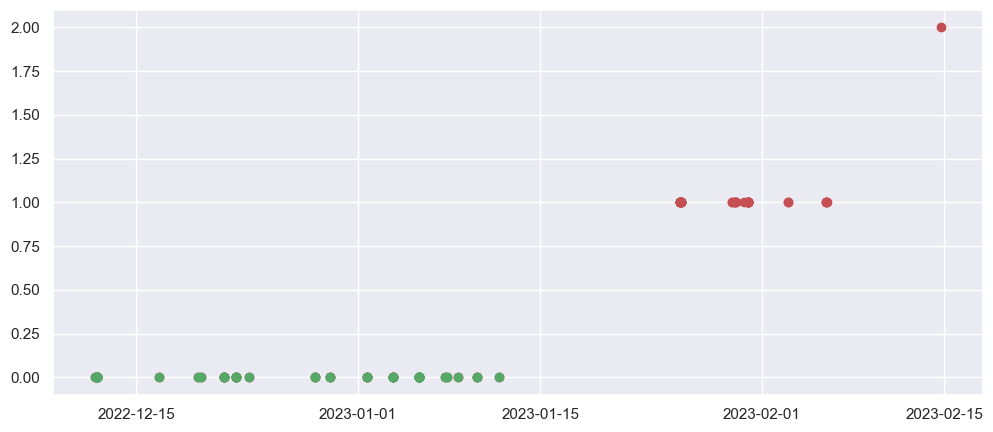

In [60]:
x, y = lnds(single_example.serial_browserversion.values)
plt.scatter(single_example.time, single_example.serial_browserversion, c='r')
plt.scatter(single_example.time.iloc[y], x, c='g')

In [301]:
len(x) / len(single_example)

0.975609756097561

### And now - using the modules

In [24]:
from hard_rules import denoised_fraction, version_serializtion

In [25]:
from lnds import longest_non_decreasing_subsequence as lnds

In [26]:
found = False
limit_search = 1000
while not found and limit_search > 0:
    limit_search -= 1
    one_cookie_sample = cookie_hhd_data[cookie_hhd_data["ok"]==False].sample()
    one_cookie_id = one_cookie_sample.index.get_level_values(1).values[0]
    one_cookie_data = data[data["iiqid"]==one_cookie_id].copy()
    browsers_of_cookie = len(one_cookie_data.browser.unique())
    os_of_cookie = len(one_cookie_data.os.unique())
    instances_of_cookie = len(one_cookie_data.time)
    if instances_of_cookie > 30 and browsers_of_cookie == 1 and os_of_cookie == 1:
        if denoised_fraction(one_cookie_data) < 0.95:
            found = True
if found:
    print("Found!")
else:
    print("Not Found")

Found!


In [27]:
denoised_fraction(one_cookie_data)

0.9375

In [28]:
denoised_fraction(one_cookie_data)

0.9375

In [29]:
versions_sorted = sorted(
        one_cookie_data.browserversion.unique(), key=cmp_to_key(compare_versions)
    )

In [30]:
vs = list(version_serializtion(one_cookie_data).values)
x, y = lnds(vs)
not_y = [i for i in range(len(one_cookie_data)) if i not in y]

[Text(0, 0, '107.0.0.0'), Text(0, 1, '108.0.0.0'), Text(0, 2, '109.0.0.0')]

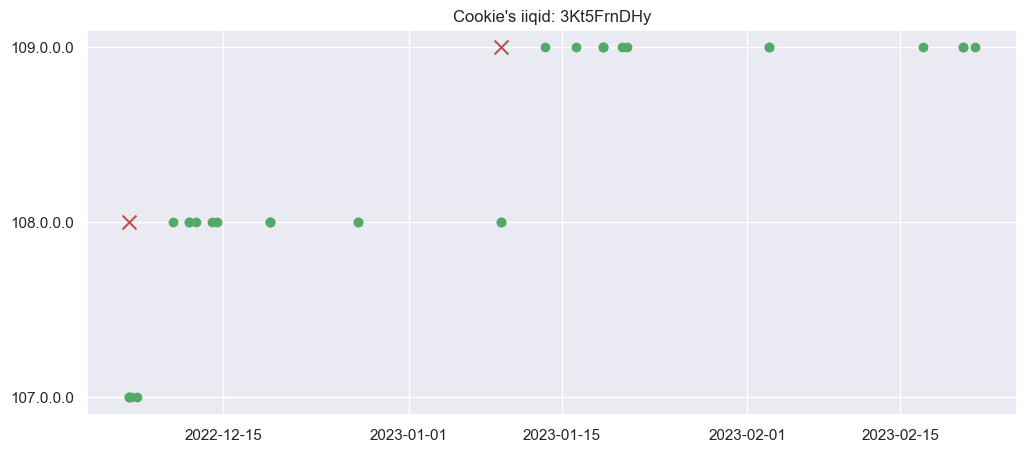

In [31]:
fig, ax = plt.subplots()
ax.scatter(one_cookie_data.time.iloc[not_y], 
           [v for i, v in enumerate(vs) if i in not_y], s=100, c='r', marker='x')
ax.scatter(one_cookie_data.time.iloc[y], x, c='g', marker='o')
ax.set_title(f"Cookie's iiqid: {one_cookie_id}")
ax.set_yticks(range(min(vs), max(vs)+1))
ax.set_yticklabels(versions_sorted)

### Treating low precision

In [34]:
ordered_versions = sorted(one_cookie_data.browserversion.unique(), key=cmp_to_key(compare_versions))

In [57]:
def version_precision(ver):
    parts = ver.split(".")
    last_nonzero_part = len(parts)
    found_non_zero = False
    for i in range(len(parts) - 1, -1, -1):
        if int(parts[i]) != 0:
            last_nonzero_part = i + 1
            found_non_zero = True
            break
    return last_nonzero_part

In [355]:
def split_by_precision(vers): 
    highest_precision = max(version_precision(v) for v in vers)
    highest_precision_versions = [v for v in vers if version_precision(v)==highest_precision]
    other_versions = [v for v in vers if v not in highest_precision_versions]
    return other_versions, highest_precision_versions, highest_precision

In [115]:
def random_version(low=1, high=2000, components=4, low_precision=False):
    if low_precision:
        rand_result = [np.random.randint(low, high)] + [0]*(components-1)
    else:
        rand_result = np.random.randint(low, high, components)
    return ".".join(map(str, rand_result))

In [359]:
no_of_vers = 20
random_versions_mix = [random_version(low=100, high= 110, components=c, low_precision=b) for b, c
                       in zip(np.random.binomial(1, 1, no_of_vers), 
                              np.random.randint(4, 5, no_of_vers))]

In [360]:
random_versions_mix

['101.0.0.0',
 '104.0.0.0',
 '107.0.0.0',
 '103.0.0.0',
 '107.0.0.0',
 '105.0.0.0',
 '103.0.0.0',
 '100.0.0.0',
 '103.0.0.0',
 '101.0.0.0',
 '108.0.0.0',
 '103.0.0.0',
 '105.0.0.0',
 '102.0.0.0',
 '103.0.0.0',
 '103.0.0.0',
 '105.0.0.0',
 '101.0.0.0',
 '105.0.0.0',
 '105.0.0.0']

In [361]:
split_by_precision(random_versions_mix)

([],
 ['101.0.0.0',
  '104.0.0.0',
  '107.0.0.0',
  '103.0.0.0',
  '107.0.0.0',
  '105.0.0.0',
  '103.0.0.0',
  '100.0.0.0',
  '103.0.0.0',
  '101.0.0.0',
  '108.0.0.0',
  '103.0.0.0',
  '105.0.0.0',
  '102.0.0.0',
  '103.0.0.0',
  '103.0.0.0',
  '105.0.0.0',
  '101.0.0.0',
  '105.0.0.0',
  '105.0.0.0'],
 1)

In [128]:
# [[trim_version(v)[0] for v in vl] for vl in split_by_precision(random_versions_mix)]
set(split_by_precision(random_versions_mix)[1])

{'101.109.101.104',
 '102.107.102.104',
 '106.103.101.100',
 '108.104.106.102',
 '109.104.102.106'}

In [148]:
def find_more_detailed_vers(ver, detailed_vers):
    detailed_set = set(detailed_vers)
    return [v for v in detailed_set if trim_version(ver)[0] == trim_version(v)[0]]

In [149]:
ver_test = split_by_precision(random_versions_mix)[0][-1]
print(ver_test)
find_more_detailed_vers(ver_test, split_by_precision(random_versions_mix)[1])

107.0.0.0


['107.107.102.103', '107.102.100.102']

#### How many mixed precision are there?

In [470]:
def mix_precision_type(hh_id, iiqid, df):
    sample_point_data = df[(df["hh_id"]==hh_id) & (df["iiqid"]==iiqid)]
    lp, hp, hpv = split_by_precision(sample_point_data["browserversion"].values)

    if lp == [] and hp == []:
        raise ValueError("The data is empty or not in the correct type/shape")
    if lp != [] and hp != []:
        main_hp_versions = [int(v.split('.')[0]) for v in hp]
        main_lp_versions = [int(v.split('.')[0]) for v in lp]
        if max(main_lp_versions) < min(main_hp_versions) / 2 or \
            max(main_hp_versions) < min(main_lp_versions) / 2:
            # Maybe it should be a different number
            ans = 1
        else:
            ans = 0
    else:
        ans = 1
    return ans, hpv

In [349]:
# df1.groupby(['A','B']).size().reset_index().rename(columns={0:'count'})
hh_and_iiq_ids = non_mixed_data.groupby(["hh_id", "iiqid", "browserversion"]).size().reset_index().rename(columns={0:'count'})

In [471]:
h, i, b, c = hh_and_iiq_ids.iloc[35]
mix_precision_type(h, i, hh_and_iiq_ids)

(1, 1)

In [472]:
hh_and_iiq_ids[(hh_and_iiq_ids["hh_id"]==h) & (hh_and_iiq_ids["iiqid"]==i)]

,hh_id,iiqid,browserversion,count
35,03M6awhGWm,RuyWbpn1m5,107.0.0.0,2
36,03M6awhGWm,RuyWbpn1m5,108.0.0.0,50
37,03M6awhGWm,RuyWbpn1m5,109.0.0.0,17


In [473]:
# precision_mixing_types = [mix_precision_type(h,i, non_mixed_data) for h, i, c in hh_and_iiq_ids.values]
precision_mixing_types = []
for h, i, b, c in tqdm(hh_and_iiq_ids.values): 
    curr_type, curr_highest_precision = mix_precision_type(h,i, hh_and_iiq_ids)
    precision_mixing_types.append((h, i, curr_type, curr_highest_precision))

100%|████████████████████████████████████| 67320/67320 [04:14<00:00, 264.99it/s]


In [474]:
mixings = [t for _,_,t,_ in precision_mixing_types]
weights = np.ones_like(mixings) / len(mixings)

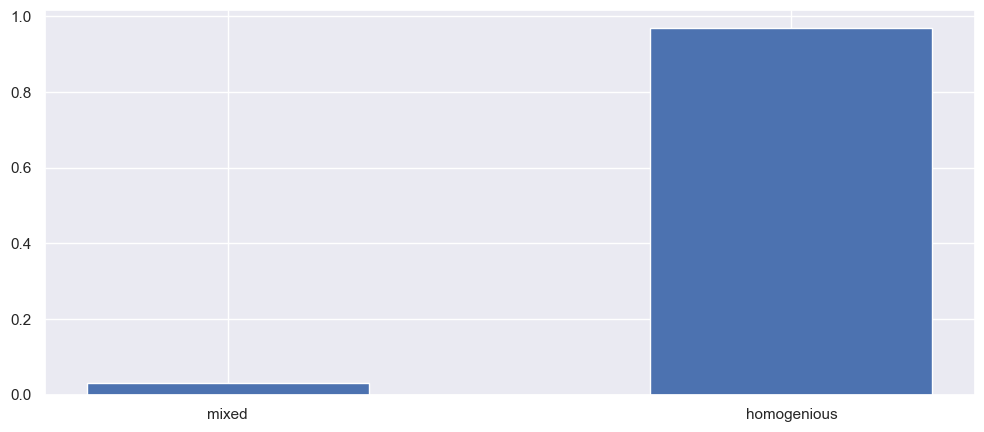

In [475]:
plt.hist(x=mixings, bins=[0,0.5, 1,1.5], weights=weights, align='left')
plt.xticks(ticks=[0,1], labels=['mixed', 'homogenious']);

In [476]:
mixings = [p for _,_,t,p in precision_mixing_types if t == 1]
weights = np.ones_like(mixings) / len(mixings)

Text(0.5, 1.0, 'Distribution of the precision of version homogenious instances')

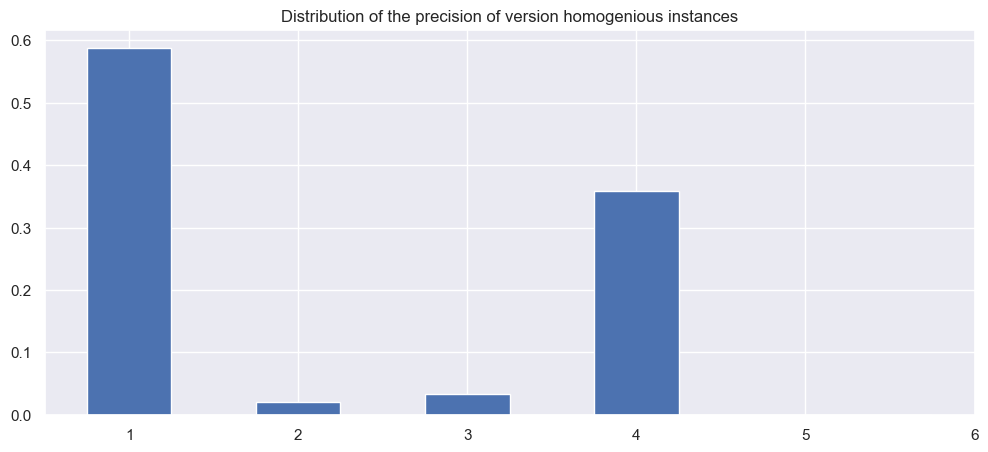

In [477]:
plt.hist(x=mixings, weights=weights, align='left')
plt.title("Distribution of the precision of version homogenious instances")

In [478]:
pd.DataFrame(mixings).value_counts(normalize=True)

1    0.587466
4    0.358711
3    0.033459
2    0.020210
6    0.000153
dtype: float64

In [395]:
mixings_df = pd.DataFrame([(not bool(t), p) for _,_,t,p in precision_mixing_types], columns=["is_mixed", "max_precision"])

In [396]:
mixings_df.head()

,is_mixed,max_precision
0,True,3
1,True,3
2,False,1
3,False,1
4,True,4


<Axes: xlabel='max_precision', ylabel='count'>

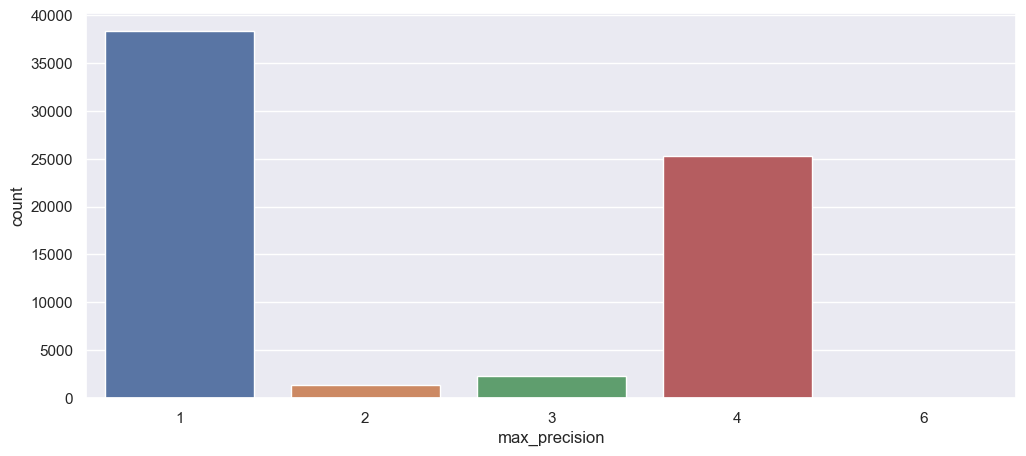

In [401]:
sns.countplot(data=mixings_df, x="max_precision")

In [479]:
mixed_vers_hh_iiq = [(h, i) for h,i,t,_ in precision_mixing_types if t==0]

In [494]:
ratios = []
# max_ratio = 0
for i in tqdm(range(len(mixed_vers_hh_iiq))):
    just_one = mixed_vers_hh_iiq[i]
    lp, hp, pp = split_by_precision(data[(data["hh_id"]==just_one[0]) & (data["iiqid"]==just_one[1])]["browserversion"])    
    m = min(len(hp)/len(lp), len(lp)/len(hp))
    ratios.append(m)
    # if len(hp)/len(lp) > max_ratio:
    # max_ratio = len(hp)/len(lp)
    # worst = split_by_precision(data[(data["hh_id"]==just_one[0]) & (data["iiqid"]==just_one[1])]["browserversion"])    

100%|███████████████████████████████████████| 2106/2106 [06:34<00:00,  5.34it/s]


<Axes: ylabel='Count'>

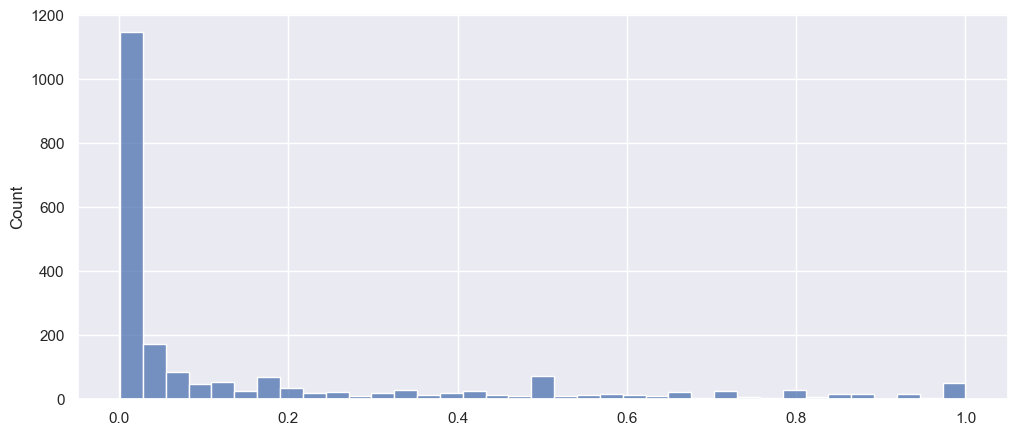

In [501]:
sns.histplot(x=ratios)

### Version Noise Distribution

In [517]:
# def no_of_os_and_browsers(one_cookie_df):
#     browsers_of_cookie = len(one_cookie_df.browser.unique())
#     os_of_cookie = len(one_cookie_df.os.unique())
#     return os_of_cookie==1 and browsers_of_cookie==1

In [511]:
cookies_noise_stats = data.groupby("iiqid").agg(denoised_fraction)

In [523]:
cookies_nuniques = data.groupby("iiqid").agg({'os': 'nunique', 'browser': 'nunique'})

In [526]:
cookie_stats = pd.concat([1-cookies_noise_stats.timestamp, cookies_nuniques], axis=1)

In [527]:
cookie_stats.columns = ["noise", "no_os", "no_browsers"]

Text(0.5, 1.0, 'Cookies Mean Noise - All cookies')

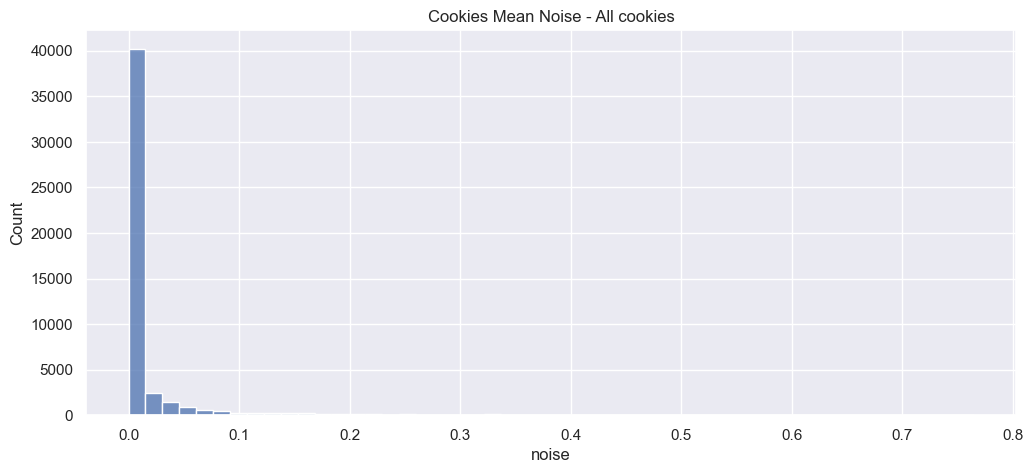

In [538]:
sns.histplot(data=cookie_stats, x="noise", bins=50)
plt.title("Cookies Mean Noise - All cookies")

Text(0.5, 1.0, 'Cookies Mean Noise - Only cookies with consistent os and browser')

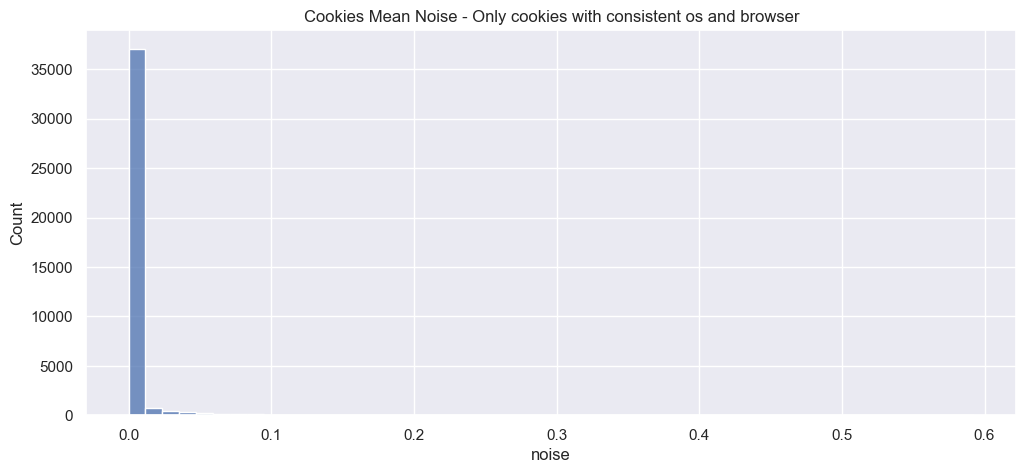

In [539]:
sns.histplot(data=cookie_stats[cookie_stats['no_os']==1], x="noise", bins=50)
plt.title("Cookies Mean Noise - Only cookies with consistent os and browser")

Text(0.5, 1.0, 'Cookies Mean Noise - Only cookies with multiple os and/or browser')

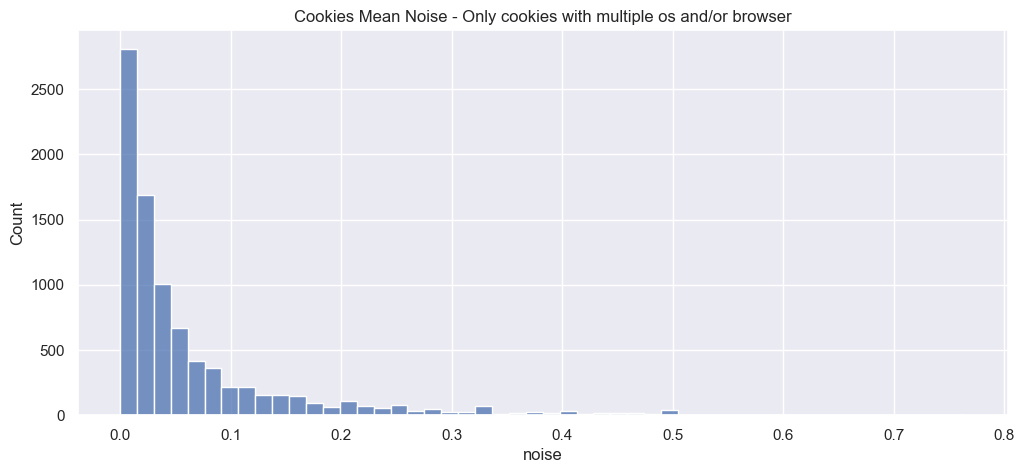

In [540]:
sns.histplot(data=cookie_stats[cookie_stats['no_os']>1], x="noise", bins=50)
plt.title("Cookies Mean Noise - Only cookies with multiple os and/or browser")

In [ ]:
sns.violinplotlinplot(data=cookie_stats, x='no_os', y='noise')

In [546]:
cookie_stats["consistent_ob"] = (cookie_stats["no_os"]==1) & (cookie_stats["no_browsers"]==1)

Text(0.5, 0, 'Is there only 1 OS and only 1 Browser attached to the cookie')

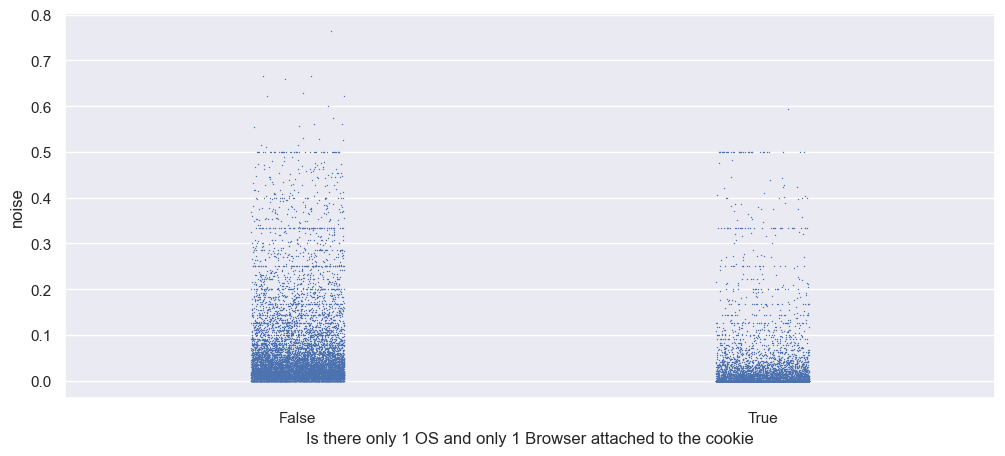

In [559]:
sns.stripplot(data=cookie_stats, x='consistent_ob', y='noise', size=1)
plt.xlabel('Is there only 1 OS and only 1 Browser attached to the cookie')

In [563]:
len(cookie_stats[(cookie_stats['consistent_ob']) & (cookie_stats['noise']>0.1)]) \
    / len(cookie_stats[cookie_stats['consistent_ob']])

0.009952949692363372

In [597]:
values, base = np.histogram(cookie_stats[cookie_stats['consistent_ob']]["noise"], bins=2000)
cumulative = np.cumsum(values)

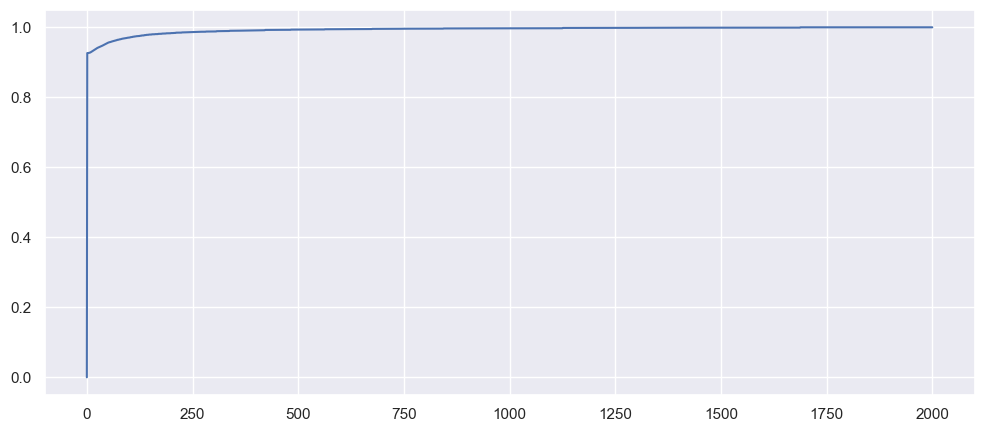

In [598]:
cdf = cumulative/len(cookie_stats[cookie_stats['consistent_ob']])
plt.plot(np.insert(cdf, 0, 0))

In [604]:
noise_values = cookie_stats[cookie_stats['consistent_ob']]["noise"].values

In [606]:
np.cumsum(noise_values.sort())

array([None], dtype=object)

In [607]:
noise_values.sort()

In [611]:
p = 1. * np.arange(len(noise_values)) / (len(noise_values) - 1)

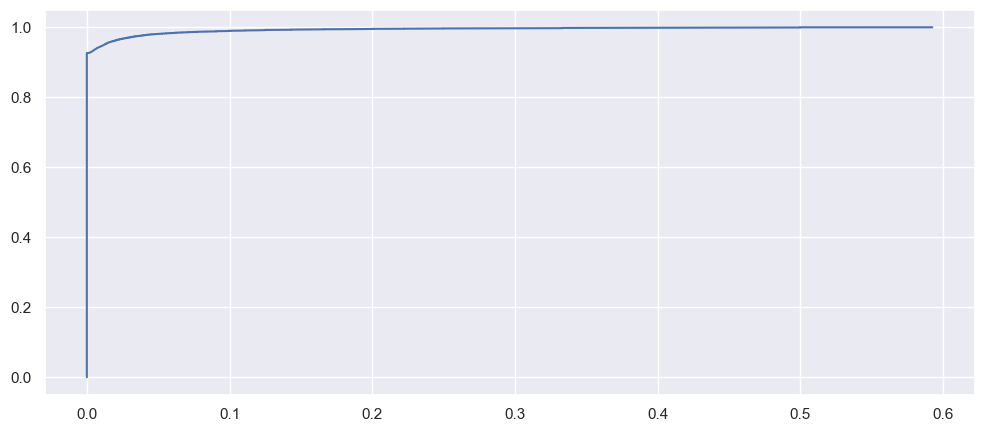

In [613]:
plt.plot(noise_values, p)

In [614]:
noise_values_bad = cookie_stats[~cookie_stats['consistent_ob']]["noise"].values

In [615]:
noise_values_bad.sort()

In [616]:
p = 1. * np.arange(len(noise_values_bad)) / (len(noise_values_bad) - 1)

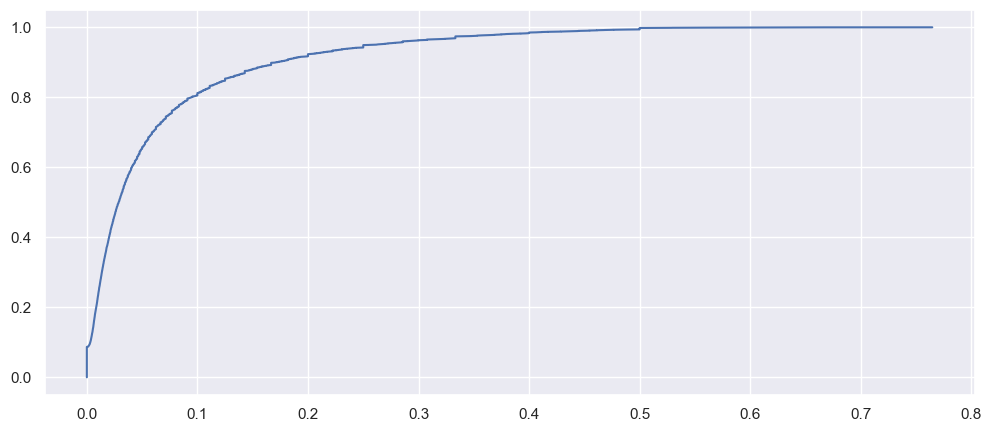

In [617]:
plt.plot(noise_values_bad, p)

In [627]:
len(noise_values[np.where(noise_values==0)])/len(noise_values)

0.9263998759112766

In [625]:
len(noise_values_bad[np.where(noise_values_bad!=0)])/len(noise_values_bad)

0.9130523315007126